<a href="https://colab.research.google.com/github/Yoomin99/LIGN167_Stock/blob/main/LIGN167_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LIGN 167: The Evaluation of Stock Prediction Models Final Project
 
- Yoomin Oh
- Suditi Bhatt
- Himanshi Gupta

Data Sources
- https://www.kaggle.com/datasets/kannan1314/amazon-stock-price-all-time
- https://www.kaggle.com/datasets/varpit94/google-stock-data
- https://www.kaggle.com/datasets/akpmpr/updated-netflix-stock-price-all-time
- https://www.kaggle.com/datasets/aaron7sun/stocknews?resource=download

Code and Referred Sources  
- https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632
- https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817/
- https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc
- https://takelab.fer.hr/podium/examples/tfidf_example.html


In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import time
import warnings
warnings.filterwarnings("ignore")

Data Frame

Data Source Citation: https://www.kaggle.com/datasets/kannan1314/amazon-stock-price-all-time

In [2]:
Amazon = pd.read_csv("DataFile/Amazon.csv")
Amazon['Date'] = pd.to_datetime(Amazon['Date'])
Amazon_2010_2017 = Amazon[~(Amazon['Date'] > '2017-12-31')]
Amazon_2010_2017 = Amazon_2010_2017[~(Amazon_2010_2017['Date'] < '2010-1-1')].reset_index(drop = True)
Amazon_2010_2017

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,130.000000,11030200
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,133.520004,9830500
...,...,...,...,...,...,...,...
2008,2017-12-22,1172.079956,1174.619995,1167.829956,1168.359985,1168.359985,1585100
2009,2017-12-26,1168.359985,1178.319946,1160.550049,1176.760010,1176.760010,2005200
2010,2017-12-27,1179.910034,1187.290039,1175.609985,1182.260010,1182.260010,1867200
2011,2017-12-28,1189.000000,1190.099976,1184.380005,1186.099976,1186.099976,1841700


In [3]:
Amazon_2017_2021 = Amazon[~(Amazon['Date'] < '2017-12-31')].reset_index(drop = True)
Amazon_2017_2021

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,1172.000000,1190.000000,1170.510010,1189.010010,1189.010010,2694500
1,2018-01-03,1188.300049,1205.489990,1188.300049,1204.199951,1204.199951,3108800
2,2018-01-04,1205.000000,1215.869995,1204.660034,1209.589966,1209.589966,3022100
3,2018-01-05,1217.510010,1229.140015,1210.000000,1229.140015,1229.140015,3544700
4,2018-01-08,1236.000000,1253.079956,1232.030029,1246.869995,1246.869995,4279500
...,...,...,...,...,...,...,...
958,2021-10-21,3414.250000,3440.280029,3403.000000,3435.010010,3435.010010,1881400
959,2021-10-22,3421.000000,3429.840088,3331.300049,3335.550049,3335.550049,3133800
960,2021-10-25,3335.000000,3347.800049,3297.699951,3320.370117,3320.370117,2226000
961,2021-10-26,3349.510010,3416.120117,3343.979980,3376.070068,3376.070068,2693700


Amazon_2010_2017 would be used to train our model. And then Amazon_2017_2020 would be used to test our model. 

In [4]:
Amazon_2010 = Amazon[~(Amazon['Date'] < '2010-1-1')].reset_index(drop = True)
Amazon_2010

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,130.000000,11030200
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,133.520004,9830500
...,...,...,...,...,...,...,...
2971,2021-10-21,3414.250000,3440.280029,3403.000000,3435.010010,3435.010010,1881400
2972,2021-10-22,3421.000000,3429.840088,3331.300049,3335.550049,3335.550049,3133800
2973,2021-10-25,3335.000000,3347.800049,3297.699951,3320.370117,3320.370117,2226000
2974,2021-10-26,3349.510010,3416.120117,3343.979980,3376.070068,3376.070068,2693700


Data Source Citation: https://www.kaggle.com/datasets/varpit94/google-stock-data

In [5]:
Google = pd.read_csv("DataFile/GOOGL.csv")
Google['Date'] = pd.to_datetime(Google['Date'])
Google_2010 = Google[~(Google['Date'] < '2010-1-1')].reset_index(drop = True)
Google_2010_2017 = Google[~(Google['Date'] > '2017-12-31')]
Google_2010_2017 = Google_2010_2017[~(Google_2010_2017['Date'] < '2010-1-1')].reset_index(drop = True)
Google_2010_2017

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,313.788788,315.070068,312.432434,313.688690,313.688690,3908488
1,2010-01-05,313.903900,314.234222,311.081085,312.307312,312.307312,6003391
2,2010-01-06,313.243256,313.243256,303.483490,304.434448,304.434448,7949443
3,2010-01-07,305.005005,305.305298,296.621613,297.347351,297.347351,12815771
4,2010-01-08,296.296295,301.926941,294.849854,301.311310,301.311310,9439151
...,...,...,...,...,...,...,...
2008,2017-12-22,1070.000000,1071.719971,1067.640015,1068.859985,1068.859985,889400
2009,2017-12-26,1068.640015,1068.859985,1058.640015,1065.849976,1065.849976,918800
2010,2017-12-27,1066.599976,1068.270020,1058.380005,1060.199951,1060.199951,1116200
2011,2017-12-28,1062.250000,1064.839966,1053.380005,1055.949951,1055.949951,994200


Google_2010_2017 would be used to train our model. And then Google_2017_2022 would be used to test our model. 

In [6]:
Google_2017_2022 = Google[~(Google['Date'] < '2017-12-31')].reset_index(drop = True)
Google_2017_2022

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,1053.020020,1075.979980,1053.020020,1073.209961,1073.209961,1588300
1,2018-01-03,1073.930054,1096.099976,1073.430054,1091.520020,1091.520020,1565900
2,2018-01-04,1097.089966,1104.079956,1094.260010,1095.760010,1095.760010,1302600
3,2018-01-05,1103.449951,1113.579956,1101.800049,1110.290039,1110.290039,1512500
4,2018-01-08,1111.000000,1119.160034,1110.000000,1114.209961,1114.209961,1232200
...,...,...,...,...,...,...,...
1060,2022-03-18,2668.489990,2724.879883,2645.169922,2722.510010,2722.510010,2223100
1061,2022-03-21,2723.270020,2741.000000,2681.850098,2722.030029,2722.030029,1341600
1062,2022-03-22,2722.030029,2821.000000,2722.030029,2797.360107,2797.360107,1774800
1063,2022-03-23,2774.050049,2791.770020,2756.699951,2765.510010,2765.510010,1257700


Data Source Citation: https://www.kaggle.com/datasets/akpmpr/updated-netflix-stock-price-all-time

In [7]:
Netflix = pd.read_csv("DataFile/netflix.csv")
Netflix['Date'] = pd.to_datetime(Netflix['Date'])
Netflix_2010 = Netflix[~(Netflix['Date'] < '2010-1-1')].reset_index(drop = True)
Netflix_2010_2017 = Netflix[~(Netflix['Date'] > '2017-12-31')]
Netflix_2010_2017 = Netflix_2010_2017[~(Netflix_2010_2017['Date'] < '2010-1-1')].reset_index(drop = True)
Netflix_2010_2017

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-01-04,7.961429,7.565714,7.931429,7.640000,17239600.0,7.640000
1,2010-01-05,7.657143,7.258571,7.652857,7.358571,23753100.0,7.358571
2,2010-01-06,7.672857,7.197143,7.361429,7.617143,23290400.0,7.617143
3,2010-01-07,7.757143,7.462857,7.731429,7.485714,9955400.0,7.485714
4,2010-01-08,7.742857,7.465714,7.498571,7.614286,8180900.0,7.614286
...,...,...,...,...,...,...,...
2008,2017-12-22,190.949997,186.800003,188.330002,189.940002,3878900.0,189.940002
2009,2017-12-26,189.940002,186.399994,189.779999,187.759995,3045700.0,187.759995
2010,2017-12-27,188.100006,185.220001,187.800003,186.240005,4002100.0,186.240005
2011,2017-12-28,194.490005,186.850006,187.179993,192.710007,10107400.0,192.710007


Netflix_2010_2017 would be used to train our model. And then Netflix_2017_2021 would be used to test our model. 

In [8]:
Netflix_2017_2021 = Netflix[~(Netflix['Date'] < '2017-12-31')].reset_index(drop = True)
Netflix_2017_2021

,Date,High,Low,Open,Close,Volume,Adj Close
0,2018-01-02,201.649994,195.419998,196.100006,201.070007,10966900.0,201.070007
1,2018-01-03,206.210007,201.500000,202.050003,205.050003,8591400.0,205.050003
2,2018-01-04,207.050003,204.000000,206.199997,205.630005,6029600.0,205.630005
3,2018-01-05,210.020004,205.589996,207.250000,209.990005,7033200.0,209.990005
4,2018-01-08,212.500000,208.440002,210.020004,212.050003,5580200.0,212.050003
...,...,...,...,...,...,...,...
946,2021-10-05,640.390015,606.890015,606.940002,634.809998,9534300.0,634.809998
947,2021-10-06,639.869995,626.359985,628.179993,639.099976,4580400.0,639.099976
948,2021-10-07,646.840027,630.450012,642.229980,631.849976,3556900.0,631.849976
949,2021-10-08,643.799988,630.859985,634.169983,632.659973,3271100.0,632.659973


Code Source Citation: https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

In [9]:
def split_data(origianl, stock, dimension):
   
    data_raw = origianl.to_numpy() # convert to numpy array
    data = []
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - dimension):
        data.append(data_raw[index: index + dimension])
    
    data = np.array(data)
 
    train_set_size = len(stock)
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]



Regession Line
 - Referred Source Citation: https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817/

In [10]:
def regressionLine(y):
    days = np.size(y)
    x = []
    for i in range(1,days+1):
        x.append(i)
    x = np.array(x)

    avgX = np.average(x)
    avgY = np.average(y)
    SumX = np.sum(x)
    SumY = np.sum(y)

    xy = 0
    xx = 0
    for i in range(len(x)):
        xy = xy + (x[i]- avgX) * (y[i] - avgY)
        xx = xx + (x[i]- avgX)**2
    
    slope = xy/xx
    b = avgY - slope*avgX
    return (b, slope)




In [11]:
def plotRegressionLine(trainDf , testDf , company, b):
    # plotting the actual points as scatter plot
    testX = []
    trainX = []
   
    for i in range(1, np.size(trainDf["Date"]) + 1):
        trainX.append(i)
    trainX = np.array(trainX)


    plt.plot(trainDf["Date"], trainDf["Close"], color = "m" , label="Traning Data")
  
    # predicted stock price
    y_pred = b[0] + b[1]*trainX
  
    # plotting the regression line
    plt.plot(trainDf["Date"], y_pred, color = "b"  )

    for i in range(1, np.size(testDf["Date"]) + 1):
        testX.append(np.size(trainDf["Date"]) + i)
    testX = np.array(testX)
    y_pred = b[0] + b[1]*testX
    MSE = np.square(np.subtract(testDf["Close"],y_pred)).mean()
    print("MSE error is ", MSE)
    plt.plot(testDf["Date"], y_pred, color = "b" ,  label = "Prediction")
    plt.plot(testDf["Date"], testDf["Close"], color = "r", label = "Testing Data")
    
    # putting labels
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(company  + " stock price from 2010 to 2015")
    plt.legend(loc='best')
    
    # function to show plot
    plt.show()

MSE error is  1956063.0838420792


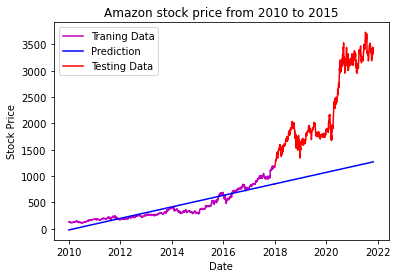

In [12]:
Amazonb = (regressionLine(Amazon_2010_2017["Close"]))
plotRegressionLine(Amazon_2010_2017 , Amazon_2017_2021,"Amazon", Amazonb)

MSE error is  535444.295454257


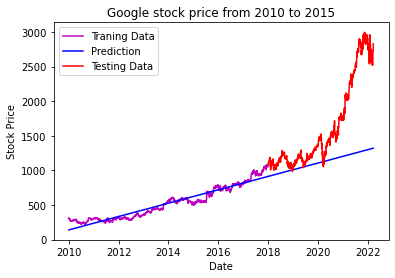

In [13]:
Googleb = (regressionLine(Google_2010_2017["Close"]))
plotRegressionLine(Google_2010_2017,Google_2017_2022 ,"Google", Googleb)

MSE error is  54292.4089322385


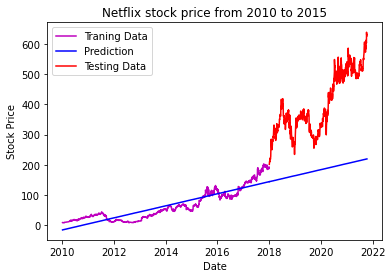

In [14]:
Netflixb = (regressionLine(Netflix_2010_2017["Close"]))
plotRegressionLine(Netflix_2010_2017,Netflix_2017_2021 , "Netflix", Netflixb)

## Logistic Regression Line
- We will use the most famous article headlines to predict whether the article is positive or negative. 
- If the result of our traning model is good enough then, we plan to use the model to predict the most famous article to predict whether the stock price goes up or down. 
- If not, then we will use the old data

Data Source Citation:
- https://www.kaggle.com/datasets/aaron7sun/stocknews?resource=download
Code Source Citation: 
- https://takelab.fer.hr/podium/examples/tfidf_example.html
Referred Source Citation:
- https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc


In [15]:

Headlines = pd.read_csv("DataFile/StockHeadlines.csv")
Headlines = Headlines[["Date" , "Label" , "Top1"]]
Headlines = Headlines[~(Headlines['Date'] < '2010-1-1')].reset_index(drop = True)
Headlines


# Convert to the lower cases
for i in range(len(Headlines)):
    Headlines["Top1"][i] =  ((Headlines["Top1"][i]))

trainX = Headlines[~(Headlines['Date'] > '2015-12-31')]
testX = Headlines[~(Headlines['Date'] < '2016-01-01')]

trainY = Headlines[~(Headlines['Date'] > '2015-12-31')]['Label'].to_numpy()
testY =  Headlines[~(Headlines['Date'] < '2016-01-01')]['Label'].to_numpy()

tfidfV = TfidfVectorizer(sublinear_tf=True , analyzer='word' , max_features=1286, tokenizer=word_tokenize )
TrainTokenX= tfidfV.fit_transform(trainX["Top1"]).toarray()
TestTokenX = tfidfV.fit_transform(testX["Top1"]).toarray()

svc = SVC(kernel= 'linear')
model =  svc.fit(TrainTokenX, trainY)

Prediction = model.predict(TestTokenX)

num = 0

for i in range(len(Prediction)):
    if Prediction[i] == testY[i]:
        num = num + 1

print("The correctness of predicting whether the article is positive or not is " , num / len(Prediction) , " %")


The correctness of predicting whether the article is positive or not is  0.6111111111111112  %


In [16]:
def logsistic(df , TrainArticle , TestArticle):

    trainX = df[~(df['Date'] > '2015-12-31')].reset_index(drop = True)
    trainX = trainX[~(trainX['Date'] < '2010-10-01')].reset_index(drop = True)

    testX = df[~(df['Date'] < '2015-12-31')].reset_index(drop = True)
    testX = testX[~(testX['Date'] > '2016-07-01')].reset_index(drop = True)

    trainY = []

    for i in range(len(trainX)):
        trainY.append(trainX["Adj Close"][i] - trainX["Open"][i])
     
    testY = []
    for i in range(len(testX)):
        testY.append(testX["Adj Close"][i] - testX["Open"][i])
    
    #X is the difference between the open stock price and adjusted stock price
    #Y is the label whether the Top1 article in that day was positive or negative. 
    from sklearn import linear_model

    X = np.array(trainY).reshape(-1,1)
    y = np.array(TrainArticle['Label'])
    logr = linear_model.LogisticRegression()
    logr.fit(X,y)

    X = np.array(testY).reshape(-1,1)
    actualY = np.array(TestArticle)
    predicted = logr.predict(np.array(X).reshape(-1,1))

    num = 0

    for i in range(len(predicted)):
        if predicted[i] == actualY[i]:
            num = num + 1
    
    print("The correctness of guessing whether the top1 article is positive or negative based on the difference between stock prices is " , num / len(Prediction) , " %")



In [17]:
logsistic(Amazon_2010 , trainX , trainY)

The correctness of guessing whether the top1 article is positive or negative based on the difference between stock prices is  0.4365079365079365  %


In [18]:
logsistic(Netflix_2010 , trainX , trainY)

The correctness of guessing whether the top1 article is positive or negative based on the difference between stock prices is  0.49206349206349204  %


In [19]:
logsistic(Google_2010 , trainX , trainY)

The correctness of guessing whether the top1 article is positive or negative based on the difference between stock prices is  0.4523809523809524  %


LSTM Model
- Code Source Citation: https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [30]:
def trainLSTM(original , data , company):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  price = data[['Close']]
  price['Close'] = scaler.fit_transform(data["Close"].values.reshape(-1,1))
  input_dim = 1
  hidden_dim = 25
  num_layers = 2
  output_dim = 1
  num_epochs = 100
  oriPrice = original[['Close']]
  oriPrice['Close'] = scaler.fit_transform(original["Close"].values.reshape(-1,1))

  x_train, y_train, x_test, y_test = split_data(oriPrice , price , hidden_dim)
  x_train = torch.from_numpy(x_train).type(torch.Tensor)
  x_test = torch.from_numpy(x_test).type(torch.Tensor)
  y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
  y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

  model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
  criterion = torch.nn.MSELoss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

  hist = np.zeros(num_epochs)
  start_time = time.time()
  lstm = []
  for t in range(num_epochs):
      y_train_pred = model(x_train)
      loss = criterion(y_train_pred, y_train_lstm)
      hist[t] = loss.item()
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

 
  y_trained_pred = model(x_test)
  PredictionY = scaler.inverse_transform(y_trained_pred.detach().numpy())

  totalX = [x for x in range(len(original))]
  trainX = totalX[:len(x_train) + hidden_dim]
  testX = totalX[len(x_train) + hidden_dim:]


  #Plot the data used for training
  # plt.plot(trainX, ActualY, marker='.', label="actual")
  plt.ylabel('Stock Price', size=15)
  plt.xlabel('Year', size=15)
  
  #Actualt graph from 2010 to end
  plt.plot(original["Date"], original["Close"], label="Actual")
  # #Plot the data used for testing
  plt.plot(original["Date"][:len(x_train) + hidden_dim], original["Close"][:len(x_train) + hidden_dim], label="Training Data" ,color = "g")

  
  plt.plot(original["Date"][len(x_train) + hidden_dim:], PredictionY, 'r', label="Prediction")

  plt.title(company + " stock")
  plt.legend(loc='best')
  plt.show()


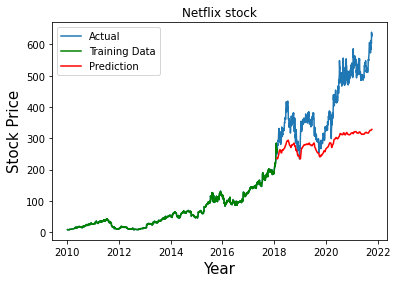

In [31]:
trainLSTM(Netflix_2010,Netflix_2010_2017 , "Netflix")

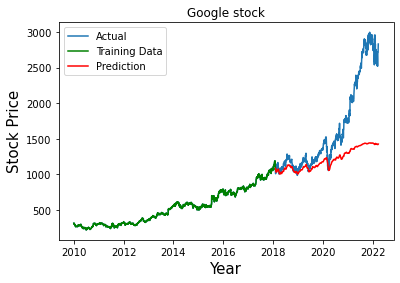

In [32]:
trainLSTM(Google_2010,Google_2010_2017 , "Google")

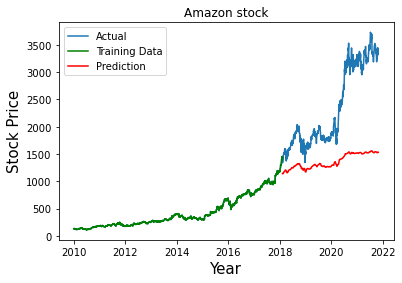

In [33]:
trainLSTM(Amazon_2010 , Amazon_2010_2017 , "Amazon")

GRU

- Code Source Citation: https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

In [25]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [26]:
def trainGRU(original , data , company):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  price = data['Close']
  input_dim = 1
  hidden_dim = 25
  num_layers = 2
  output_dim = 1
  num_epochs = 100
  oriPrice = original[['Close']]
  oriPrice['Close'] = scaler.fit_transform(original["Close"].values.reshape(-1,1))

  x_train, y_train, x_test, y_test = split_data(oriPrice,price, hidden_dim)
  x_train = torch.from_numpy(x_train).type(torch.Tensor)
  x_test = torch.from_numpy(x_test).type(torch.Tensor)
  y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
  y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
  model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
  criterion = torch.nn.MSELoss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
  hist = np.zeros(num_epochs)
  lstm = []
  for t in range(num_epochs):
      y_train_pred = model(x_train)
      loss = criterion(y_train_pred, y_train_lstm)
      hist[t] = loss.item()
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
  
  y_trained_pred = model(x_test)
  PredictionY = scaler.inverse_transform(y_trained_pred.detach().numpy())

  totalX = [x for x in range(len(original))]
  trainX = totalX[:len(x_train) + hidden_dim]
  testX = totalX[len(x_train) + hidden_dim:]


  #Plot the data used for training
  plt.ylabel('Stock Price', size=15)
  plt.xlabel('Year', size=15)
  
  #Actualt graph from 2010 to end
  plt.plot(original["Date"], original["Close"], label="Actual")
  # #Plot the data used for testing
  plt.plot(original["Date"][:len(x_train) + hidden_dim], original["Close"][:len(x_train) + hidden_dim], label="Training Data" ,color = "g")
  plt.plot(original["Date"][len(x_train) + hidden_dim:], PredictionY, 'r', label='Prediction')
  plt.legend(loc='best')
  plt.title(company + " stock")
  plt.show()

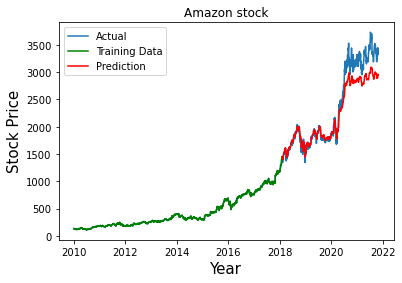

In [27]:
trainGRU(Amazon_2010 , Amazon_2010_2017 , "Amazon")

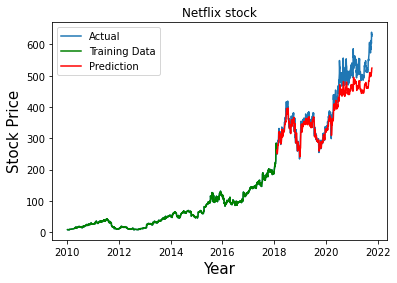

In [28]:
trainGRU(Netflix_2010 , Netflix_2010_2017 , "Netflix")

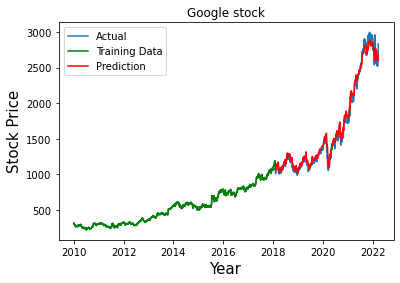

In [29]:
trainGRU(Google_2010 , Google_2010_2017 , "Google")